# Notebook for exercise 2

- Christos Kounsolas
- 10345
- ΤΗΜΜΥ

## 0. Get data ready

### 0.1 Create X_train, X_test, y_train, test 

This is the same procedure that i did in the previous tasks too.

In [48]:
# Import the necessary libraries
import os   #helps me erase a warning that i am getting
import numpy as np  #the data are numpy when i first get them
from sklearn.preprocessing import StandardScaler  #need this for standardizing the data
from sklearn.decomposition import PCA #need this for the PCA in the data
import torch
from torch import nn #need this for my model (layers, loss functions, ...)
from sklearn.metrics import accuracy_score #need this to measure the accuracy of the model
import time  #need this to calcualate the training time
from pathlib import Path #need this for the save_model(). 
import matplotlib.pyplot as plt  # need this for the model's plots
import pandas as pd 
from sklearn.svm import SVC #need this for the SVM model
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV #need this for the GridSearchCV model which is used to find the best hyperparameters

from sklearn.multiclass import OneVsRestClassifier #need this for the OneVsRestClassifier model, which is used to make the SVM model multiclass
from sklearn.metrics.pairwise import euclidean_distances 
from sklearn.model_selection import RandomizedSearchCV #need this for the RandomizedSearchCV model which is used to find the best hyperparameters and it is faster than GridSearchCV
from sklearn.ensemble import BaggingClassifier #need this for the BaggingClassifier model , which makes the model more robust
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import torch
import numpy as np
from sklearn.metrics import pairwise as sklearn_pairwise


os.environ["LOKY_MAX_CPU_COUNT"] = "8"  # This line erases a warning that i am getting

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] #the names of the classes      

file_names = []
files = []
#create X_train, y_train, X_test, y_test
X_train = np.full((50000,3072),0,dtype=int)
X_test = np.full((10000,3072),0,dtype=int)
y_train = np.full((50000,),0,dtype=int)
y_test = np.full((10000,),0,dtype=int)

# the unpickle() function loads the CIFAR-10 data from the file
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Creating a list with the names of the files
for i in range(1,6):
    file = f"data_batch_{i}"
    file_names.append(file)
file_names.append("test_batch")

#storing the unpickled dictionaries to a list
for file in file_names:
    cifar10_dict = unpickle(file)
    files.append(cifar10_dict)

# Splitting the data to train and test set
# Printing the shapes to make sure that everything went well
i=0
for file in files:
    print(f"Append: {file[b'batch_label']}")
    if file[b'batch_label'] != b'testing batch 1 of 1':
        #this is the X_train, y_train
        X_train[i*10000:(i+1)*10000,:] = file[b'data']
        y_train[i*10000:(i+1)*10000] = file[b'labels'] 
        i+=1
       
    else:
        #i have just finished X_train, y_train   
        #this is the X_test, y_test
        X_test[:,:] = file[b'data']
        y_test[:] = file[b'labels']
        print(f"Shape X_train: {X_train.shape}\nShape y_train: {y_train.shape}")
        print(f"Shape X_test: {X_test.shape}\nShape y_test: {y_test.shape}\n")
        
        
    

Append: b'training batch 1 of 5'
Append: b'training batch 2 of 5'
Append: b'training batch 3 of 5'
Append: b'training batch 4 of 5'
Append: b'training batch 5 of 5'
Append: b'testing batch 1 of 1'
Shape X_train: (50000, 3072)
Shape y_train: (50000,)
Shape X_test: (10000, 3072)
Shape y_test: (10000,)



### 0.2 Reduce the dimensions using PCA and normalize the data using StandardScaler

- PCA reduces the computational cost and the risk of overfitting by eliminating redundant or less informative features.
- With the StandardScaler we normalize the data so that each feature has a mean of 0 and a standard deviation of 1. 

In [49]:
pca = PCA(n_components = 0.92) #i want to keep 92% of the variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

scaler = StandardScaler()
X_train_sc_pca = scaler.fit_transform(X_train_pca)
X_test_sc_pca = scaler.transform(X_test_pca)

print(f"X_train_sc_pca.shape = {X_train_sc_pca.shape}")
print(f"X_test_sc_pca.shape = {X_test_sc_pca.shape}")


X_train_sc_pca.shape = (50000, 131)
X_test_sc_pca.shape = (10000, 131)


### 0.3 Creating Training and testing data for class 0 and 1

For the kernel hyperparameter of the SVM model, i consider 3 choices:
1. linear
2. rbf
3. poly

So i am thinking that i should see how well these 3 kernels perform with images, without having to wait 90+ minutes to see the results (90+ minutes if i use GridSearchCV to find the best hyperparameters). To do that i will take only two classes (0,1) and the problem will be converted to binary . I wont have to wait a lot to see the results. I will also apply PCA and normalize the data for the 2 classes

In [3]:
y_train2 = []
X_train2 = []
y_test2 = []
X_test2 = []

#For training
for idx,value in enumerate(y_train):
    if value == 0 or value == 1:
        y_train2.append(value)
        X_train2.append(X_train[idx,:]) #i am using the original data, not the PCA data and i am taking the whole row

X_train2=np.array(X_train2)
y_train2=np.array(y_train2)

#For testing 
for idx,value in enumerate(y_test):
    if value == 0 or value == 1:
        y_test2.append(value)
        X_test2.append(X_test[idx,:]) #i am using the original data, not the PCA data and i am taking the whole row

X_test2=np.array(X_test2)
y_test2=np.array(y_test2)

print(f"X_train2.shape = {X_train2.shape}")
print(f"y_train2.shape = {y_train2.shape}")
print(f"X_test2.shape = {X_test2.shape}")
print(f"y_test2.shape = {y_test2.shape}")

pca = PCA(n_components = 0.92)
scaler = StandardScaler()

X_train2_pca = pca.fit_transform(X_train2)
X_test2_pca = pca.transform(X_test2)

X_train2_sc_pca = scaler.fit_transform(X_train2_pca)
X_test2_sc_pca = scaler.transform(X_test2_pca)

print(f"X_train2_sc_pca.shape = {X_train2_sc_pca.shape}")
print(f"X_test2_sc_pca.shape = {X_test2_sc_pca.shape}")

X_train2.shape = (10000, 3072)
y_train2.shape = (10000,)
X_test2.shape = (2000, 3072)
y_test2.shape = (2000,)
X_train2_sc_pca.shape = (10000, 125)
X_test2_sc_pca.shape = (2000, 125)


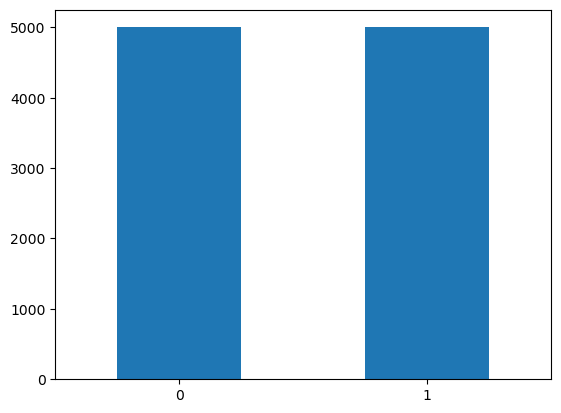

In [4]:
# making sure that the training data are balanced
pd.Series(y_train2).value_counts().sort_index().plot(kind='bar', rot=0);

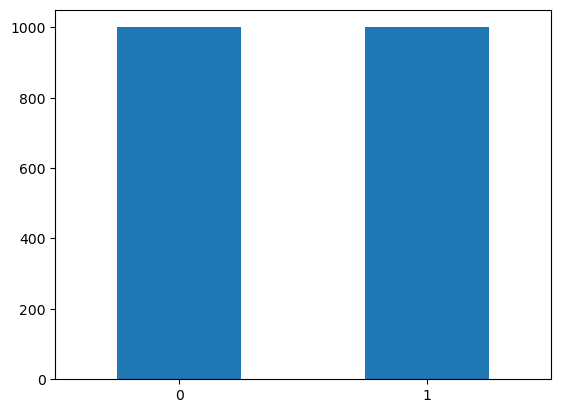

In [5]:
# making sure that the testing data are balanced
pd.Series(y_test2).value_counts().sort_index().plot(kind='bar', rot=0);

## 1.  SVM models

### 1.1 Create functions to help me train, test and evaluate the model

- train_test_model()

This function trains and test the model and also prints the accuracy 

- evaluate_svm()

This function displays the confusion matrix, the classification report and 10 miscalssified images





In [6]:

def train_test_model(model,X_train,X_test,y_train,y_test):
    start_time = time.time()
    
    model.fit(X_train,y_train)

    y_pred = model.predict(X_test)

    end_time=time.time()

    acc = accuracy_score(y_test,y_pred)

    print(f"Total time: {(end_time-start_time):.2f}s | Test accuracy: {round(acc*100,2):.2f}%")

    return round(acc*100,2)



# this function is used to evaluate the SVM model and plot the confusion matrix, the classification report and the misclassified images
def evaluate_model(model, X_test, y_test, X_test_original): 

    y_pred = model.predict(X_test)

    # Plotting the confusion matrix
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title("Confusion Matrix")
    display(plt.show())

    # Printing the classification report
    report = classification_report(y_test, y_pred, digits=3, target_names=class_names)
    print(report)

    # Identifying misclassified indices
    misclassified_idx = np.where(y_test != y_pred)[0]

    # Plotting misclassified images
    fig, axes = plt.subplots(2, 5, figsize=(15, 8))
    for i, ax in enumerate(axes.flat): 
        if i >= len(misclassified_idx):
            ax.axis('off')
        else:
            idx = misclassified_idx[i]
            img = X_test_original[idx]

            # Ensure the image has the correct shape
            if img.shape == (3, 32, 32):
                img = img.transpose([1,2,0])
                ax.imshow(img)  # Display original image
            else:
                img = img.reshape(3,32,32)
                img = img.transpose([1,2,0])
                ax.imshow(img)
                

            
            ax.set_title(f"Label: {class_names[y_test[idx]]}, Pred: {class_names[y_pred[idx]]}")
            
            ax.axis('off')

    plt.tight_layout()
    plt.show()







Lets see how time consuming is the default SVM model in the pca reduced and scaled dataset

In [50]:
svm_v0 = SVC()
acc = train_test_model(svm_v0,X_train_sc_pca,X_test_sc_pca,y_train,y_test)




Total time: 640.76s | Test accuracy: 56.68%


### 1.2 SVMs for binary classification

From the above cell i see that the default SVM in the PCA reduced dataset takes roughly 10 minutes. I can't tune the hyperparameters if each model takes this much time. So i will use only the 1st and 2nd class and i will see how well SVMs with different kernels perform

In [8]:
# lets first use the default hyperparameters
svm_v1 = SVC()
acc = train_test_model(svm_v1,X_train2_sc_pca,X_test2_sc_pca,y_train2,y_test2)



Total time: 10.32s | Test accuracy: 90.60%


RandomizedSearchCV() doesnt test all the parameters available, but tests a given number of the parameters, choosing them randomly. 

I choose this, rather than GridSearchCV because GridSearchCV tests all the parameters which takes too much time

In [9]:
# A low C encourages a simpler model with a wider margin but may lead to some misclassifications.
# A high C tries to classify all training points correctly, potentially causing overfitting

# Small coef0: Focuses on higher-degree polynomial terms, capturing more complex relationships in data.
# Large coef0: Gives more importance to lower-degree terms, leading to simpler decision boundaries.

# Small gamma values: A wide influence, resulting in a smoother decision boundary (underfitting risk).
# Large gamma values: A narrow influence, allowing the model to fit more details (overfitting risk).

# Set up RandomizedSearchCV

param_grid={
    "kernel":["poly"],
    "degree":[2,3,4,5], 
    "gamma":[0.001,0.01,0.1,1],
    "C":[0.1,1,10],   #
    "coef0":[0,1,10]
}

random_search_poly = RandomizedSearchCV(SVC(),param_grid,n_iter=40,cv=3,scoring="accuracy",n_jobs=-1, random_state=42,verbose=1)

random_search_poly.fit(X_train2_sc_pca,y_train2)

print(f"\nBest randomSearch poly parameters: {random_search_poly.best_params_}")

# return the best estimator
best_randomSearch_poly = random_search_poly.best_estimator_

y_pred2_best_randomSearch_poly = best_randomSearch_poly.predict(X_test2_sc_pca) #predicting the test data

best_randomSearch_poly_acc = accuracy_score(y_test2,y_pred2_best_randomSearch_poly) #calculating the accuracy   

print(f"Best randomSearch poly accuracy: {round(best_randomSearch_poly_acc*100,2)}%")





Fitting 3 folds for each of 40 candidates, totalling 120 fits

Best randomSearch poly parameters: {'kernel': 'poly', 'gamma': 0.001, 'degree': 5, 'coef0': 1, 'C': 10}
Best randomSearch poly accuracy: 91.05%


In [ ]:
# When to Use the RBF Kernel
# Nonlinear Problems: When the relationship between features and classes is not linear.



param_grid = {
    "C": [0.1, 1, 10, 100, 200],  # Regularization parameter
    "gamma": [0.001, 0.01, 0.1, 1],  # RBF kernel parameter
    "kernel": ["rbf"],
    'tol': [1e-4, 1e-3, 1e-2]
}

random_search_rbf = RandomizedSearchCV(SVC(), param_grid,n_iter=40,cv=3, scoring="accuracy", n_jobs=-1, random_state=42,verbose=1)

random_search_rbf.fit(X_train2_sc_pca,y_train2)

print(f"\nBest parameters: {random_search_rbf.best_params_}")

# return the best estimator
best_randomSearch_rbf = random_search_rbf.best_estimator_

y_pred2_best_randomSearch_rbf = best_randomSearch_rbf.predict(X_test2_sc_pca)

best_randomSearch_rbf_acc = accuracy_score(y_test2,y_pred2_best_randomSearch_rbf)

print(f"Best randomSearch rbf accuracy: {round(best_randomSearch_rbf_acc*100,2)}%")


Fitting 3 folds for each of 40 candidates, totalling 120 fits

Best parameters: {'tol': 0.01, 'kernel': 'rbf', 'gamma': 0.01, 'C': 10}
Best randomSearch rbf accuracy: 90.65%


In [11]:
# When to Use the Linear Kernel

# Linearly Separable Data: Works well if the classes can be separated with a straight line or a hyperplane.
# High-Dimensional Data: Performs well in cases where the number of features is very large (e.g., text classification, where features are word counts or embeddings).
# Efficiency: Faster to compute compared to non-linear kernels (like RBF or polynomial), as it avoids complex transformations.
# Low Noise: Best suited for datasets with less noise or overlap between classes.

param_grid = {
    "kernel":["linear"],
    "C": [0.1, 1, 10, 100],
    'tol': [1e-4, 1e-3, 1e-2]
}

random_search_linear = RandomizedSearchCV(SVC(), param_grid, n_iter=12,cv=3, scoring="accuracy", n_jobs=-1, random_state=42, verbose=1)

random_search_linear.fit(X_train2_sc_pca,y_train2)

print(f"\nBest parameters: {random_search_linear.best_params_}")

# return the best estimator
best_randomSearch_linear = random_search_linear.best_estimator_

y_pred2_best_randomSearch_linear = best_randomSearch_linear.predict(X_test2_sc_pca)

best_randomSearch_linear_acc = accuracy_score(y_test2,y_pred2_best_randomSearch_linear)

print(f"Best randomSearch linear accuracy: {round(best_randomSearch_linear_acc*100,2)}%")

Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters: {'tol': 0.01, 'kernel': 'linear', 'C': 10}
Best randomSearch linear accuracy: 82.7%


### 1.3 SVMs for multiclass classification

From the above, i think that the kernels that work best for images are the rbf and the poly. So below i will use all the classes and i will try to find the best hyperparameters for a Support Vector Model. But first lets make sure that the SVM with the linear kernel doesnt perform well, so that i wont need to test this type of SVM later on.

Total time: 1567.03s | Test accuracy: 41.25%


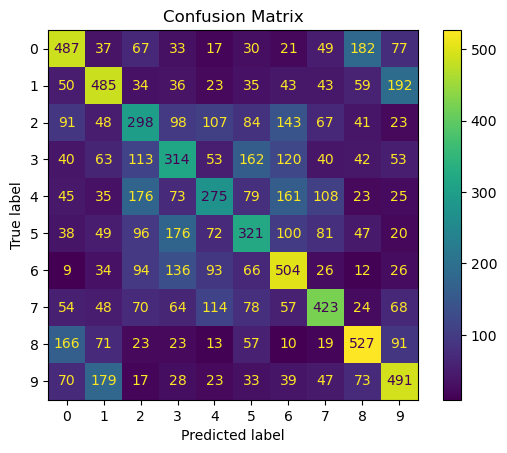

None

              precision    recall  f1-score   support

    airplane      0.464     0.487     0.475      1000
  automobile      0.462     0.485     0.473      1000
        bird      0.302     0.298     0.300      1000
         cat      0.320     0.314     0.317      1000
        deer      0.348     0.275     0.307      1000
         dog      0.340     0.321     0.330      1000
        frog      0.421     0.504     0.459      1000
       horse      0.468     0.423     0.445      1000
        ship      0.512     0.527     0.519      1000
       truck      0.461     0.491     0.475      1000

    accuracy                          0.412     10000
   macro avg      0.410     0.412     0.410     10000
weighted avg      0.410     0.412     0.410     10000



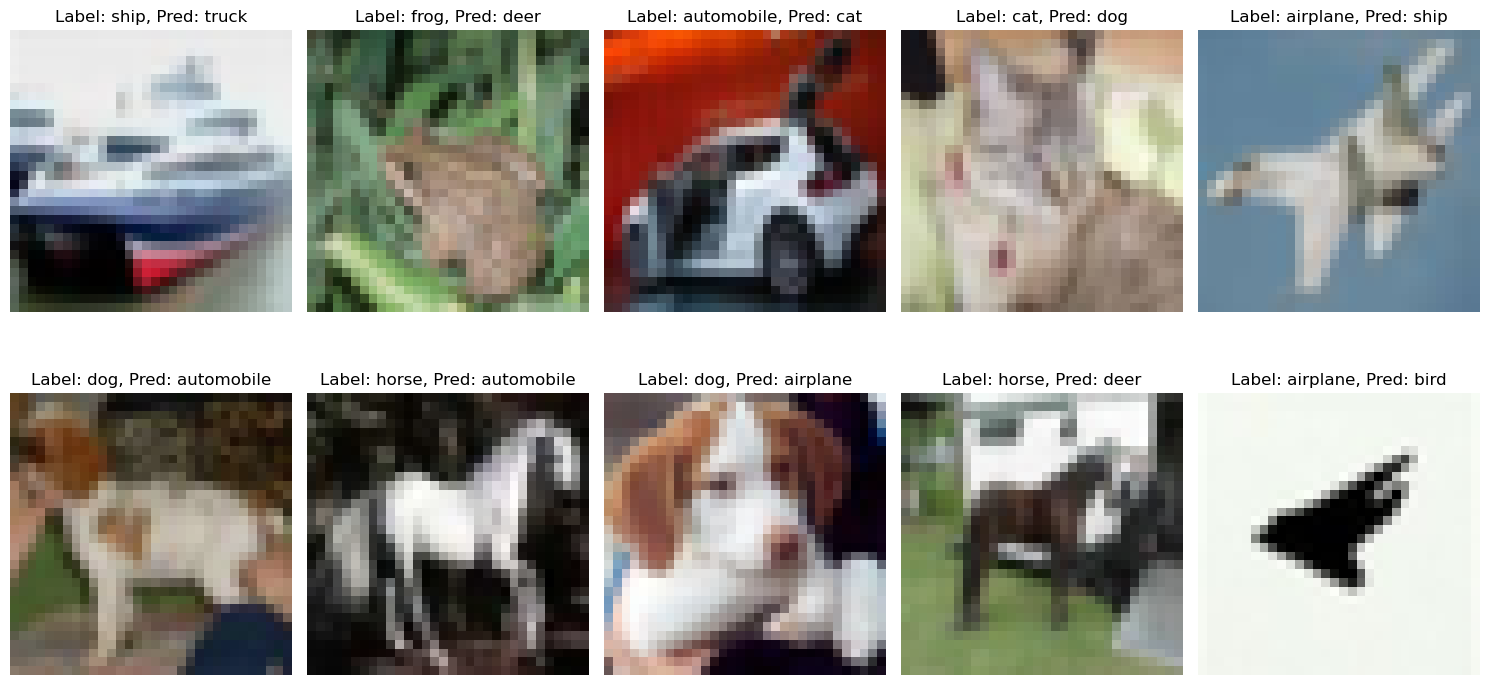

In [12]:
svm_linear = SVC(kernel = "linear")

train_test_model(svm_linear,X_train_sc_pca,X_test_sc_pca,y_train,y_test)

evaluate_model(svm_linear, X_test_sc_pca, y_test, X_test)

Using all the samples for the training and the testing of the model is too time consuming. So i will create a function that keeps 80% of the most common images and 20% of the outiliers images for each class. I will be able to reduce the size of the dataset, but also extract important conclusions about which hyperparameters make our model better. I used ChatGPT for the following function and made some adjustments to fully implement my idea.

In [13]:
def reduce_dataset_combined(X, y, num_samples_per_class):
   
    X = np.array(X)
    y = np.array(y)
    unique_classes = np.unique(y)
    X_reduced, y_reduced = [], []
    rep_ratio = 0.8  # 80% representative, 20% diverse

    for cls in unique_classes:
        # Get samples belonging to this class
        X_cls = X[y == cls]
        y_cls = y[y == cls]
        
        # Compute the average sample for the class
        avg_sample = np.mean(X_cls, axis=0, keepdims=True)
        
        # Compute distances of all samples to the average sample
        distances = sklearn_pairwise.euclidean_distances(X_cls, avg_sample).flatten()
        
        # Split indices into representative and diverse
        num_representative = int(rep_ratio * num_samples_per_class)
        num_diverse = num_samples_per_class - num_representative

        representative_indices = np.argsort(distances)[:num_representative]
        diverse_indices = np.argsort(distances)[-num_diverse:]
        
        # Combine selected samples
        selected_indices = np.concatenate((representative_indices, diverse_indices))
        
        X_reduced.append(X_cls[selected_indices])
        y_reduced.append(y_cls[selected_indices])
    
    # Combine all reduced samples
    X_reduced = np.vstack(X_reduced)
    y_reduced = np.hstack(y_reduced)
    
    # Shuffle the combined data while keeping the pairs intact
    indices = np.random.permutation(X_reduced.shape[0])
    X_reduced = X_reduced[indices]
    y_reduced = y_reduced[indices]
    
    return X_reduced, y_reduced


In [14]:
#Reducing the size of the training data to 3500 samples for each class
X_train_reduced,y_train_reduced = reduce_dataset_combined(X_train_sc_pca,y_train,3500)

X_train_reduced.shape, y_train_reduced.shape

((35000, 131), (35000,))

In [15]:
#train and test the default SVM to see what accuracy we get
train_test_model(SVC(),X_train_reduced,X_test_sc_pca,y_train_reduced,y_test)

Total time: 279.25s | Test accuracy: 53.52%


53.52

Finding the best combination of hyperparameters for my SVM is too time consuming. Thats why i am using the RandomizedSearchCV. This way i use many sets of hyperparameters and i get the combination that gives the best accuracy. I chose the RandomizedSearchCV rather than the GridSearchCV because the GridSearchCV uses all the combinations of the given hyperparameters, but this makes it too time consuming. On the other hand RandomizedSearchCV doesnt try all the combinations, making it faster .

- RandomizedSearchCV for the rbf kernel

In [16]:
# Define the parameter distribution
param_dist = {
        'kernel': ['rbf'],
        'C': [ 0.1, 1, 10, 100],
        'gamma': [1e-3, 0.01, 0.1, 1],
        'shrinking': [True, False],
        'tol': [1e-4, 1e-3, 1e-2]
}

# Initialize the SVM
svm = SVC()

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_dist,
    n_iter=75,  # Number of different combinations to try
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',  # Metric to optimize
    n_jobs=-1,  # Use all available cores
    random_state=42,  # Reproducibility
    verbose=1  # Print messages
)

# Fit the model
random_search.fit(X_train_reduced, y_train_reduced)

# Print the best parameters and score
print(f"Best randomSearch rbf parameters: {random_search.best_params_}")
 
# To use the best estimator
best_randomSearch_rbf10 = random_search.best_estimator_


Fitting 3 folds for each of 75 candidates, totalling 225 fits
Best randomSearch rbf parameters: {'tol': 0.01, 'shrinking': True, 'kernel': 'rbf', 'gamma': 0.01, 'C': 10}


In [17]:
y_pred_best_randomSearch_rbf10 = best_randomSearch_rbf10.predict(X_test_sc_pca)
best_randomSearch_rbf10_acc = accuracy_score(y_test,y_pred_best_randomSearch_rbf10)
print(f"best randomSearch accuracy: {round(best_randomSearch_rbf10_acc*100,2)}%")

best randomSearch accuracy: 54.35%


- RandomizedSearchCV for the poly kernel

In [18]:
param_dist = {
        'kernel': ['poly'],
        'C': [ 0.1, 1, 10, 100],
        'gamma': [1e-3, 0.01, 0.1, 1],
        'degree': [2, 3, 4, 5],
        'coef0': [0.0, 0.1, 0.5, 1.0],
        'shrinking': [True, False],
        'tol': [1e-4, 1e-3, 1e-2] 
}
    
       



# Initialize RandomizedSearchCV with conditional parameter grid
random_search = RandomizedSearchCV(
    estimator=SVC(),
    param_distributions=param_dist,
    n_iter=75,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42 # Reproducibility
)

# Fit the model
random_search.fit(X_train_reduced, y_train_reduced)

# Print the best parameters and score
print(f"Best randomSearch poly parameters: {random_search.best_params_}")

# To use the best estimator
best_randomSearch_poly10 = random_search.best_estimator_


Fitting 3 folds for each of 75 candidates, totalling 225 fits
Best randomSearch poly parameters: {'tol': 0.0001, 'shrinking': False, 'kernel': 'poly', 'gamma': 0.01, 'degree': 2, 'coef0': 0.5, 'C': 1}


In [19]:
y_pred_best_randomSearch_poly10 = best_randomSearch_poly10.predict(X_test_sc_pca)
best_randomSearch_poly10_acc = balanced_accuracy_score(y_test,y_pred_best_randomSearch_poly10)
print(f"best random search poly accuracy: {round(best_randomSearch_poly10_acc*100,2)}%")

best random search poly accuracy: 54.23%


In [ ]:
#find the best model
best_svm = best_randomSearch_poly10 if best_randomSearch_poly10_acc > best_randomSearch_rbf10_acc else best_randomSearch_rbf10
best_svm

SVC(C=10, gamma=0.01, tol=0.01)

In [21]:
#Now use the whole dataset for the best model that i got from the RandomizedSearchCV
train_test_model(best_svm,X_train_sc_pca,X_test_sc_pca,y_train,y_test)

Total time: 1340.62s | Test accuracy: 57.40%


57.4

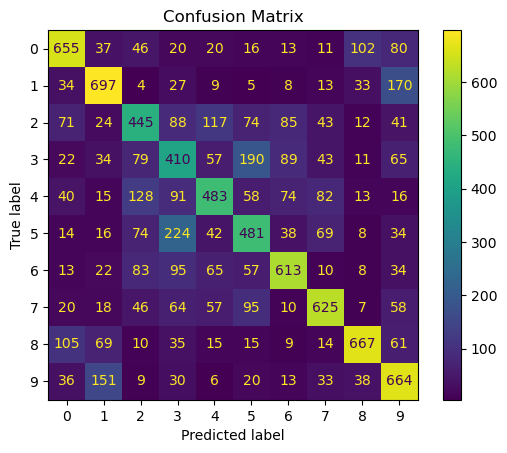

None

              precision    recall  f1-score   support

    airplane      0.649     0.655     0.652      1000
  automobile      0.644     0.697     0.669      1000
        bird      0.482     0.445     0.463      1000
         cat      0.378     0.410     0.393      1000
        deer      0.555     0.483     0.516      1000
         dog      0.476     0.481     0.478      1000
        frog      0.644     0.613     0.628      1000
       horse      0.663     0.625     0.643      1000
        ship      0.742     0.667     0.702      1000
       truck      0.543     0.664     0.597      1000

    accuracy                          0.574     10000
   macro avg      0.577     0.574     0.574     10000
weighted avg      0.577     0.574     0.574     10000



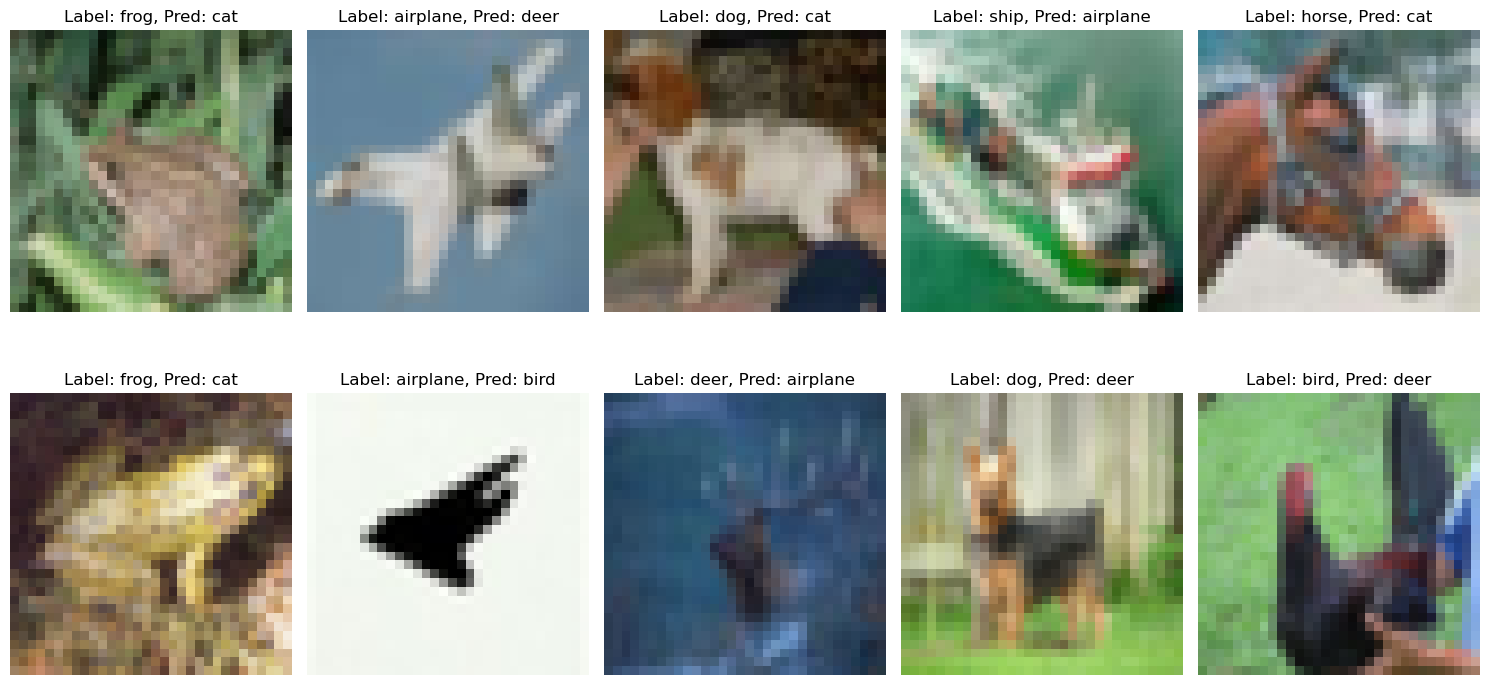

In [22]:
evaluate_model(best_svm,X_test_sc_pca,y_test,X_test)

### 1.4 Bagging

Bagging is an ensemble learning technique aimed at improving the performance and robustness of machine learning models. 

This technique creates multiple subsets of the training dataset by randomly sampling with replacement. This way some samples might be picked multible times, when others might not be picked, making each subset slightly different due to randomness.

The svm with the best combination of hyperparameters from the above cells is trained on each bootstrap subset.

Using majority voting the bagging model determines the final prediction

In [23]:
bagging_model = BaggingClassifier(
    estimator = best_svm,
    n_estimators = 100,   #this way i will train 100 base models (best_svm)
    random_state = 42,
    n_jobs = -1
)

#use the whole dataset for the bagging model
acc = train_test_model(bagging_model,X_train_sc_pca,X_test_sc_pca,y_train,y_test)





Total time: 12725.06s | Test accuracy: 57.20%


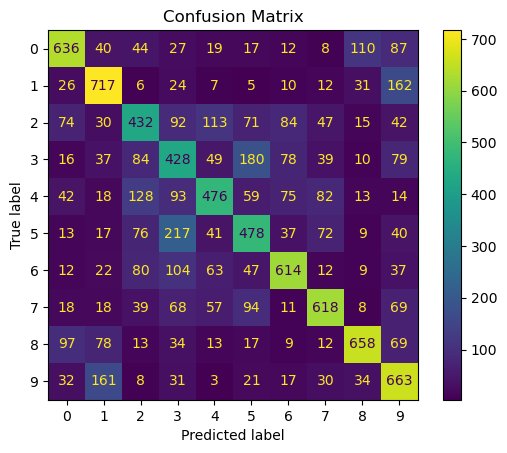

None

              precision    recall  f1-score   support

    airplane      0.658     0.636     0.647      1000
  automobile      0.630     0.717     0.671      1000
        bird      0.475     0.432     0.452      1000
         cat      0.383     0.428     0.404      1000
        deer      0.566     0.476     0.517      1000
         dog      0.483     0.478     0.481      1000
        frog      0.648     0.614     0.631      1000
       horse      0.663     0.618     0.640      1000
        ship      0.734     0.658     0.694      1000
       truck      0.525     0.663     0.586      1000

    accuracy                          0.572     10000
   macro avg      0.577     0.572     0.572     10000
weighted avg      0.577     0.572     0.572     10000



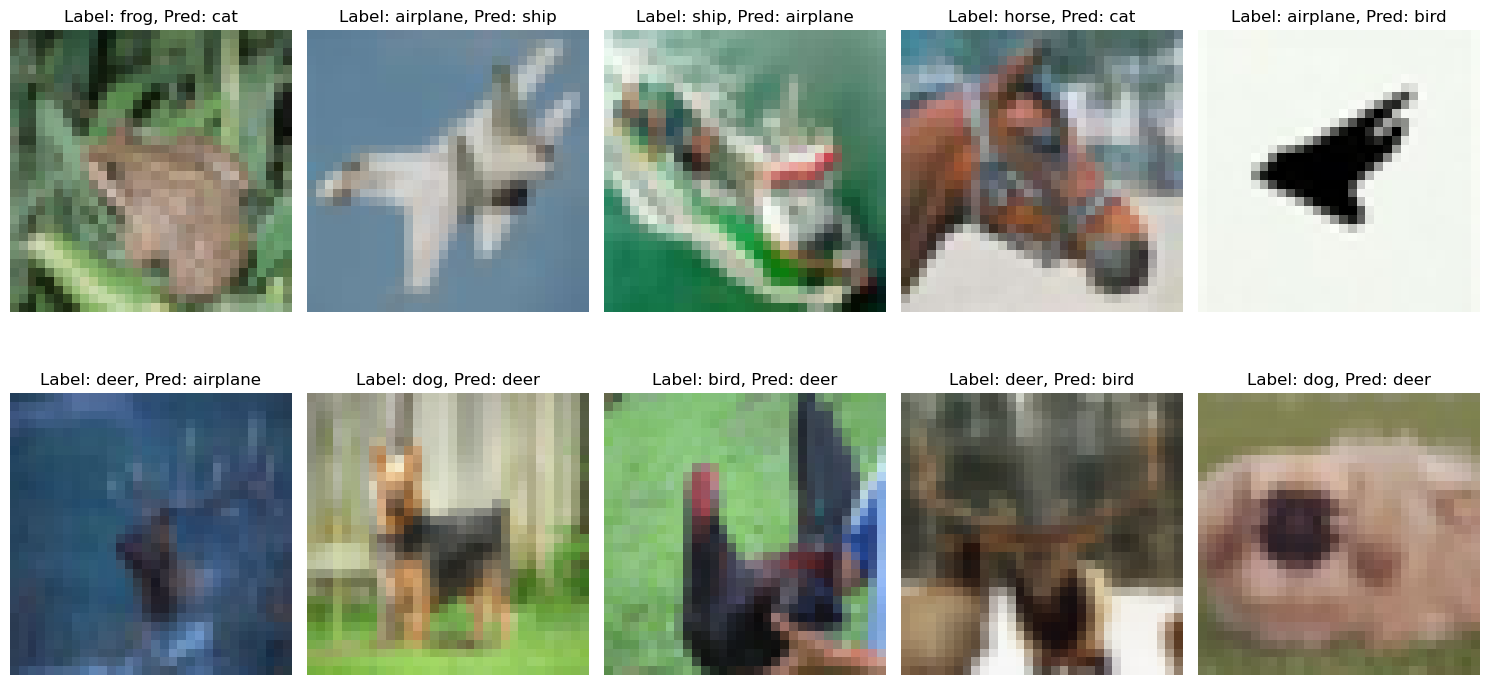

In [24]:
evaluate_model(bagging_model,X_test_sc_pca,y_test,X_test)

## 2. Compare with KNN

Below i will compare the performance of the best SVM with 1NN and 3NN. 

I will look into the report of Task0 to find the best hyperparameters for the 1NN.

Having checked my previous report i can say that the best 1NN was achieved with:
- scaled and PCA transformed data
- weights = distance
- metric = cosine

### 2.1 Compare with the best 1NN from Task0

Total time: 9.03s | Test accuracy: 44.65%


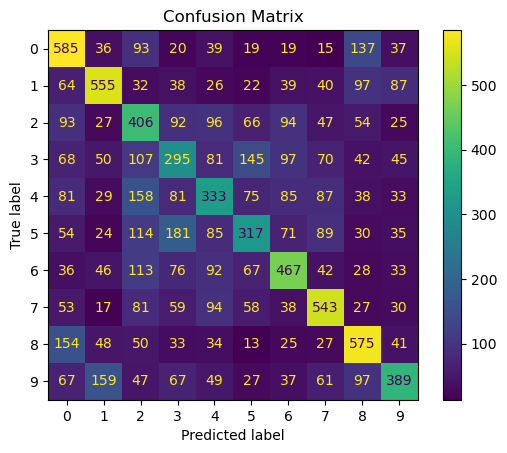

None

              precision    recall  f1-score   support

    airplane      0.466     0.585     0.519      1000
  automobile      0.560     0.555     0.558      1000
        bird      0.338     0.406     0.369      1000
         cat      0.313     0.295     0.304      1000
        deer      0.358     0.333     0.345      1000
         dog      0.392     0.317     0.350      1000
        frog      0.480     0.467     0.474      1000
       horse      0.532     0.543     0.537      1000
        ship      0.511     0.575     0.541      1000
       truck      0.515     0.389     0.443      1000

    accuracy                          0.447     10000
   macro avg      0.447     0.447     0.444     10000
weighted avg      0.447     0.447     0.444     10000



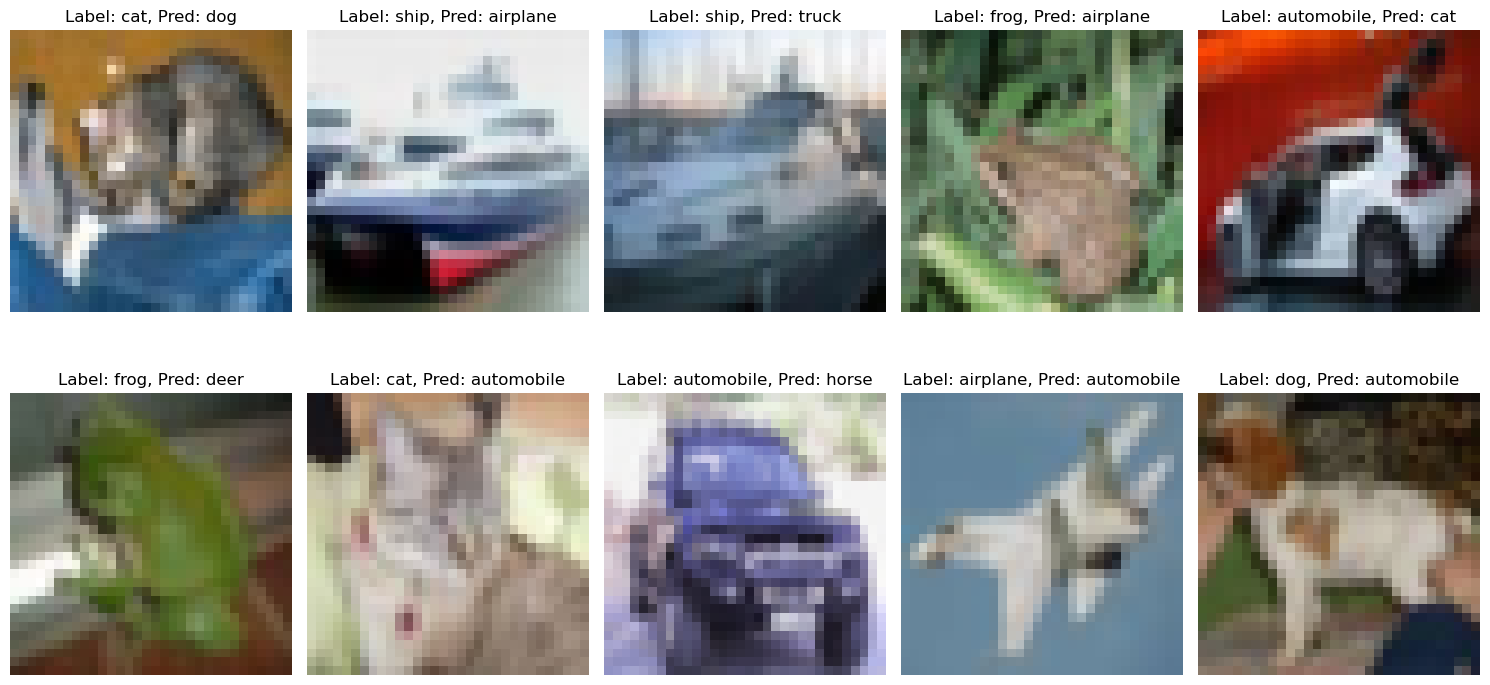

In [25]:
from sklearn.neighbors  import KNeighborsClassifier

clf_1nn = KNeighborsClassifier(n_neighbors=1,n_jobs=-1,weights="distance",metric="cosine") 

train_test_model(clf_1nn,X_train_sc_pca,X_test_sc_pca,y_train,y_test)

evaluate_model(clf_1nn,X_test_sc_pca,y_test,X_test)

### 2.2 Compare with the best 3NN from Task0

Having checked my previous report i wii display the 3NN with the following hyperparameters:
- scaled and PCA transformed data
- weight = distance
- metric = cosine

Total time: 8.84s | Test accuracy: 46.93%


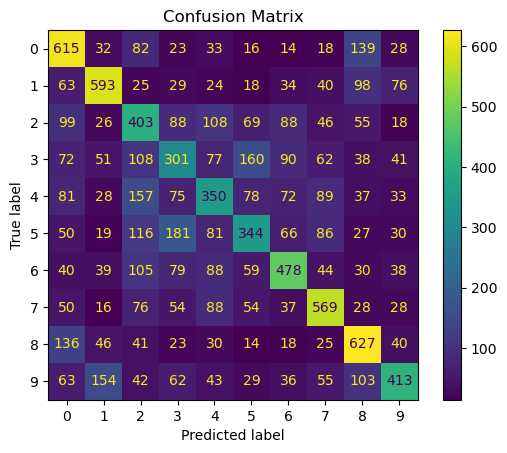

None

              precision    recall  f1-score   support

    airplane      0.485     0.615     0.542      1000
  automobile      0.591     0.593     0.592      1000
        bird      0.349     0.403     0.374      1000
         cat      0.329     0.301     0.314      1000
        deer      0.380     0.350     0.364      1000
         dog      0.409     0.344     0.374      1000
        frog      0.512     0.478     0.495      1000
       horse      0.550     0.569     0.559      1000
        ship      0.530     0.627     0.575      1000
       truck      0.554     0.413     0.473      1000

    accuracy                          0.469     10000
   macro avg      0.469     0.469     0.466     10000
weighted avg      0.469     0.469     0.466     10000



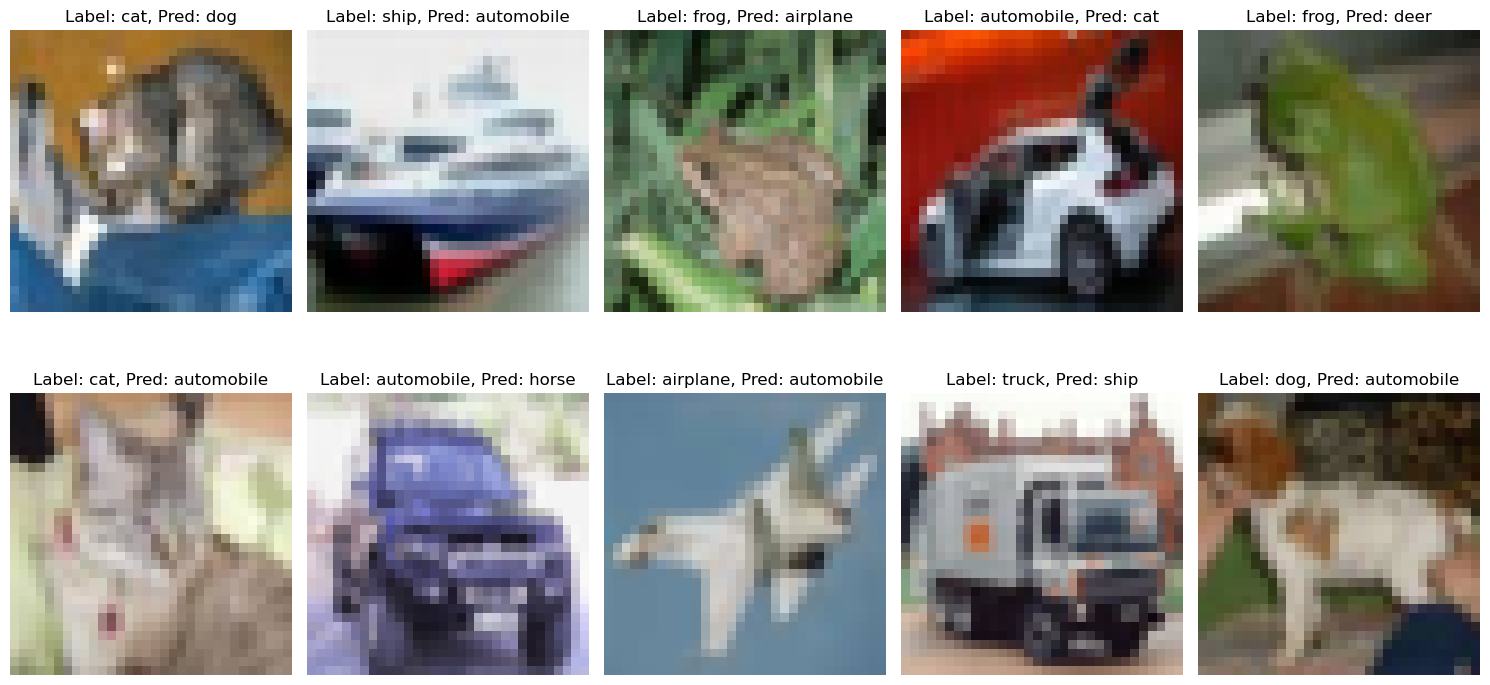

In [26]:
clf_3nn = KNeighborsClassifier(n_neighbors=3,n_jobs=-1,weights="distance",metric="cosine")

train_test_model(clf_3nn,X_train_sc_pca,X_test_sc_pca,y_train,y_test)

evaluate_model(clf_3nn,X_test_sc_pca,y_test,X_test)

## 3. Compare with Nearest Class Centroid

Having looked into Task0, i decide that i will use the GridSearchCV to find the best hyperparameters for the Nearest Class Centroid.

In [27]:
from sklearn.neighbors import NearestCentroid

param_grid = {
    "metric":["euclidean","manhattan"],
    "shrink_threshold":[0.2,0.4,0.5,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]
}

clf_nc = NearestCentroid()

grid_search = GridSearchCV(clf_nc,param_grid,cv=3,scoring="accuracy",n_jobs=-1,verbose=1)

grid_search.fit(X_train_sc_pca,y_train)

print(f"\nBest parameters: {grid_search.best_params_}")

best_grid_search_NC = grid_search.best_estimator_

y_pred_best_grid_search_NC = best_grid_search_NC.predict(X_test_sc_pca)

best_grid_search_NC_acc = accuracy_score(y_test,y_pred_best_grid_search_NC)

print(f"Best grid search NC accuracy: {round(best_grid_search_NC_acc*100,2)}%")


Fitting 3 folds for each of 22 candidates, totalling 66 fits

Best parameters: {'metric': 'euclidean', 'shrink_threshold': 0.5}
Best grid search NC accuracy: 40.56%


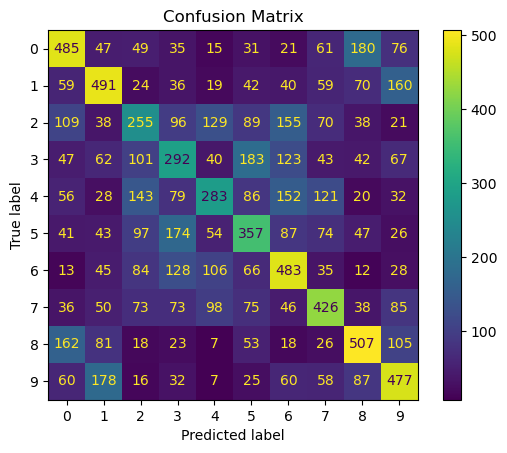

None

              precision    recall  f1-score   support

    airplane      0.454     0.485     0.469      1000
  automobile      0.462     0.491     0.476      1000
        bird      0.297     0.255     0.274      1000
         cat      0.302     0.292     0.297      1000
        deer      0.373     0.283     0.322      1000
         dog      0.355     0.357     0.356      1000
        frog      0.408     0.483     0.442      1000
       horse      0.438     0.426     0.432      1000
        ship      0.487     0.507     0.497      1000
       truck      0.443     0.477     0.459      1000

    accuracy                          0.406     10000
   macro avg      0.402     0.406     0.402     10000
weighted avg      0.402     0.406     0.402     10000



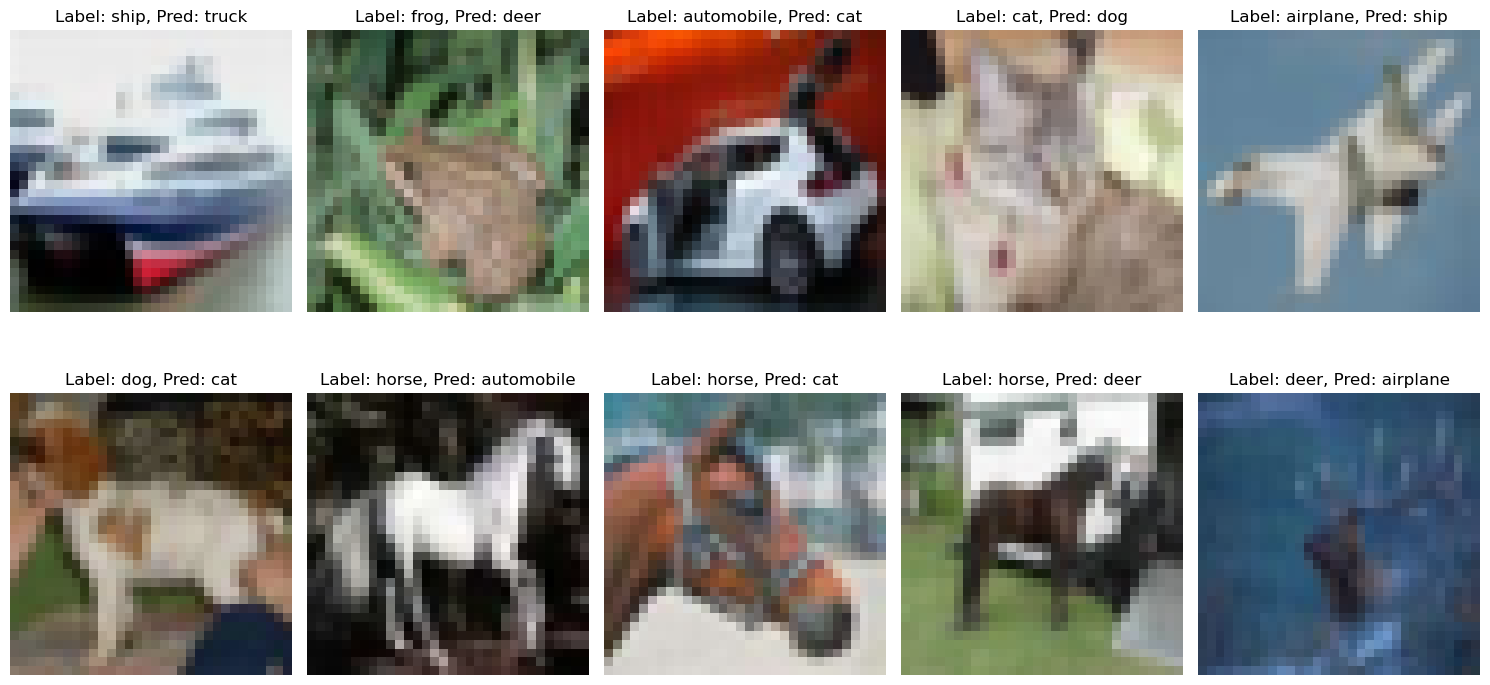

In [28]:
evaluate_model(best_grid_search_NC,X_test_sc_pca,y_test,X_test)

## 4. Compare with MLP

In [29]:
# Device agnostic code
#run the code on a GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"

In [30]:
#this is a MLP with 1 hidden layer

NUM_FEATURES = X_train_sc_pca.shape[1] #number of features  of the scaled and PCA data

NUM_CLASSES = 10

class mlp(nn.Module):
    def __init__(self,input_features,output_features,hidden_units):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)
        )

    def forward(self,x):
        return self.layer_stack(x)


In [40]:
    
mlp_model = mlp(input_features=NUM_FEATURES,output_features=NUM_CLASSES,hidden_units=1024).to(device)

loss_fn = nn.MultiMarginLoss() #this is the loss function
optimizer = torch.optim.SGD(params=mlp_model.parameters(),lr=0.1, momentum=0.6)

mlp_model


mlp(
  (layer_stack): Sequential(
    (0): Linear(in_features=131, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [32]:
# put the data to the device
#also be careful to convert the y to long tensor because the loss function needs it
X_train_sc_pca = torch.tensor(X_train_sc_pca,dtype=torch.float32).to(device)
y_train = torch.tensor(y_train,dtype=torch.long).to(device)
X_test_sc_pca = torch.tensor(X_test_sc_pca,dtype=torch.float32).to(device)
y_test = torch.tensor(y_test,dtype=torch.long).to(device)
mlp_model.to(device)


mlp(
  (layer_stack): Sequential(
    (0): Linear(in_features=131, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [41]:
epochs = 2000
start_time = time.time()    

for epoch in range(epochs):
    ### Training the model
    # Put the model in training mode
    mlp_model.train()

    #forward pass
    y_logits = mlp_model(X_train_sc_pca)
    #Calculate the loss
    loss = loss_fn(y_logits,y_train)
    train_acc = accuracy_score(y_train.cpu(), torch.argmax(y_logits, dim=1).cpu())
    #optimizer zero grad
    optimizer.zero_grad()
    #loss backward
    loss.backward()
    #optimizer step
    optimizer.step()

    ###Testing the model
    #put the model in evaluation mode
    mlp_model.eval()
    with torch.inference_mode():
        #Forward pass
        test_logits = mlp_model(X_test_sc_pca)
        #Calculate the loss
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_score(y_test.cpu(), torch.argmax(test_logits, dim=1).cpu())

    end_time = time.time()  

    #Print the results
    if epoch % (epochs//10) == 0 or epoch == epochs-1:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {train_acc:.2f} | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f} | Total time: {(end_time-start_time):.2f}s")


    
    

    

    



Epoch: 0 | Loss: 0.89525, Acc: 0.10 | Test Loss: 0.87933, Test Acc: 0.11 | Total time: 0.24s
Epoch: 200 | Loss: 0.35768, Acc: 0.46 | Test Loss: 0.38121, Test Acc: 0.43 | Total time: 5.65s
Epoch: 400 | Loss: 0.30369, Acc: 0.50 | Test Loss: 0.34328, Test Acc: 0.46 | Total time: 10.98s
Epoch: 600 | Loss: 0.26055, Acc: 0.55 | Test Loss: 0.31634, Test Acc: 0.49 | Total time: 16.38s
Epoch: 800 | Loss: 0.22660, Acc: 0.59 | Test Loss: 0.29819, Test Acc: 0.51 | Total time: 21.70s
Epoch: 1000 | Loss: 0.20006, Acc: 0.62 | Test Loss: 0.28648, Test Acc: 0.52 | Total time: 27.03s
Epoch: 1200 | Loss: 0.17873, Acc: 0.65 | Test Loss: 0.27885, Test Acc: 0.53 | Total time: 32.49s
Epoch: 1400 | Loss: 0.16115, Acc: 0.67 | Test Loss: 0.27419, Test Acc: 0.53 | Total time: 37.95s
Epoch: 1600 | Loss: 0.14640, Acc: 0.69 | Test Loss: 0.27160, Test Acc: 0.54 | Total time: 43.37s
Epoch: 1800 | Loss: 0.13388, Acc: 0.71 | Test Loss: 0.27014, Test Acc: 0.54 | Total time: 48.67s
Epoch: 1999 | Loss: 0.12311, Acc: 0.72 

In [42]:
# Print the classification report for the last epoch 
report = classification_report(y_test.cpu(), torch.argmax(test_logits,dim=1).cpu(), digits=3, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    airplane      0.596     0.595     0.595      1000
  automobile      0.652     0.639     0.645      1000
        bird      0.413     0.399     0.406      1000
         cat      0.371     0.362     0.366      1000
        deer      0.481     0.508     0.494      1000
         dog      0.452     0.446     0.449      1000
        frog      0.594     0.631     0.612      1000
       horse      0.619     0.589     0.603      1000
        ship      0.621     0.669     0.644      1000
       truck      0.594     0.560     0.576      1000

    accuracy                          0.540     10000
   macro avg      0.539     0.540     0.539     10000
weighted avg      0.539     0.540     0.539     10000



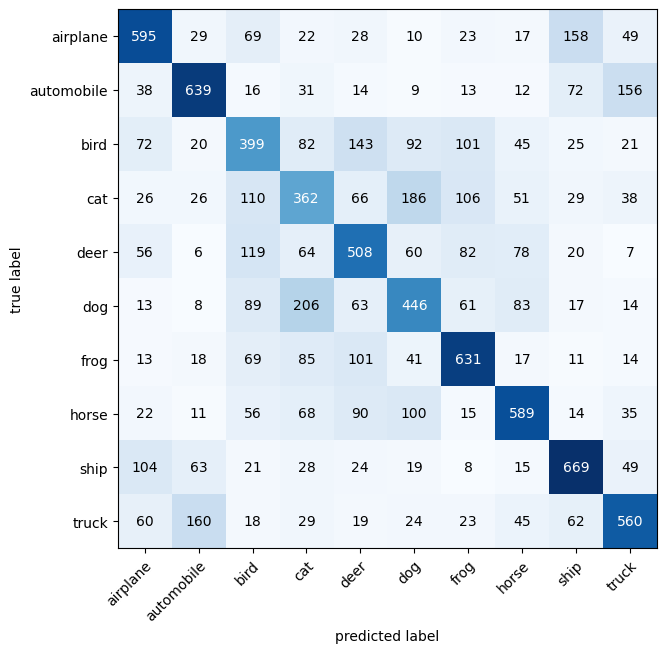

In [43]:
# Print the confusion matrix for the last epoch
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=torch.argmax(test_logits,dim=1).cpu(),
                         target=y_test.cpu())

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

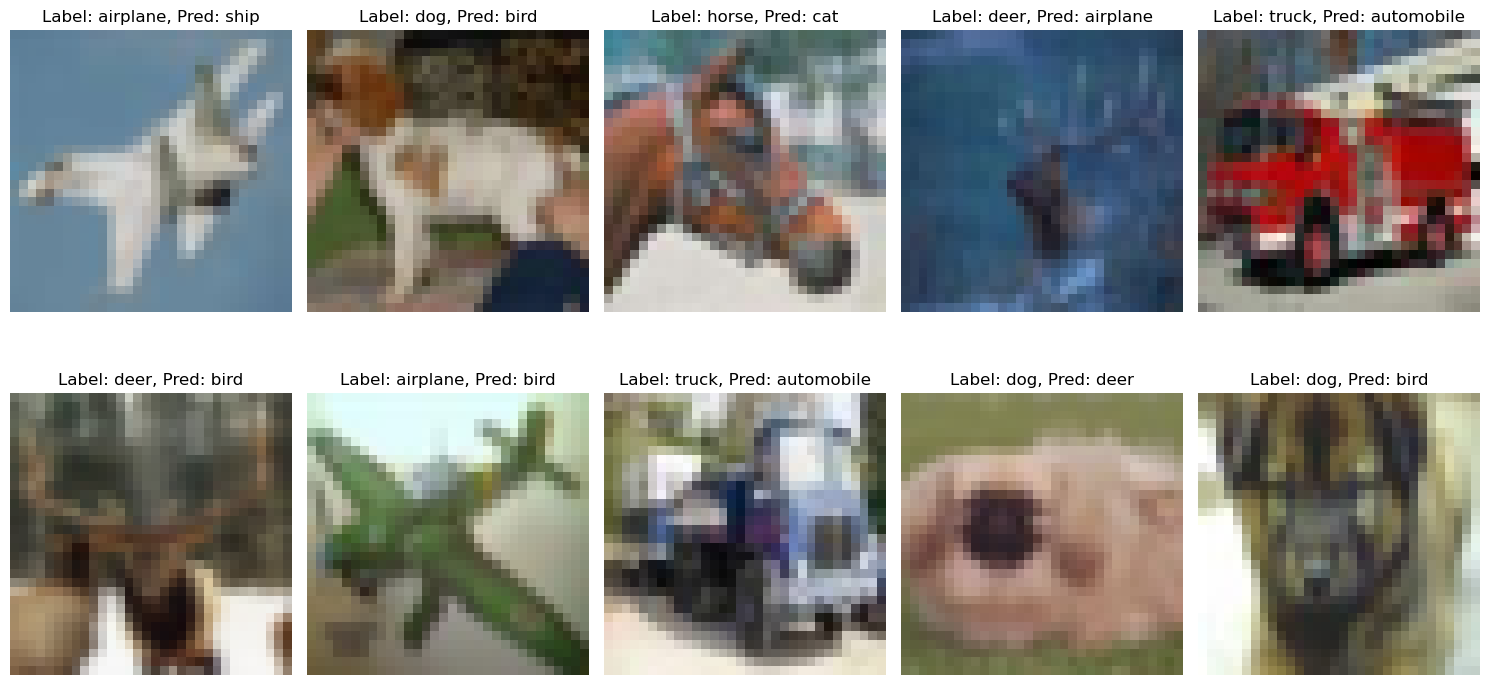

In [44]:
# show 10 misclassified images
# Identifying misclassified indices
test_pred = torch.argmax(test_logits,dim=1).cpu().numpy()
misclassified_idx = np.where(y_test.cpu().numpy() != test_pred)[0]

# Plotting misclassified images
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
for i, ax in enumerate(axes.flat): 
    if i >= len(misclassified_idx):
        ax.axis('off')
    else:
        idx = misclassified_idx[i]
        img = X_test[idx]

        # Ensure the image has the correct shape
        if img.shape == (3, 32, 32):
            img = img.transpose([1,2,0])
            ax.imshow(img)  # Display original image
        else:
            img = img.reshape(3,32,32)
            img = img.transpose([1,2,0])
            ax.imshow(img)
            

        #ax.set_title(f"Label: {class_names[y_test[idx]]} , Pred: {class_names[y_pred[idx]]}")
        ax.set_title(f"Label: {class_names[y_test[idx]]}, Pred: {class_names[test_pred[idx]]}")
        
        ax.axis('off')

plt.tight_layout()
plt.show()


## 6. Conclusion

Having seen all the above models (SVM, 1NN, 3NN, NC, MLP) trying to classify the CIFAR10 dataset, i can say that the highest accuracy was achieved by the SVM, with the help of the RandommizedGridSearchCV that helped me find the best hyperparameters. 

Also the Bagging model that has the best SVM as base estimator achieved roughly the same accuracy as the best SVM, which makes sense because i used 100 models of this SVM and i made my predictions based on the number of votes each class had from my estimators that were 100 instances of the best SVM